65.19385707414267


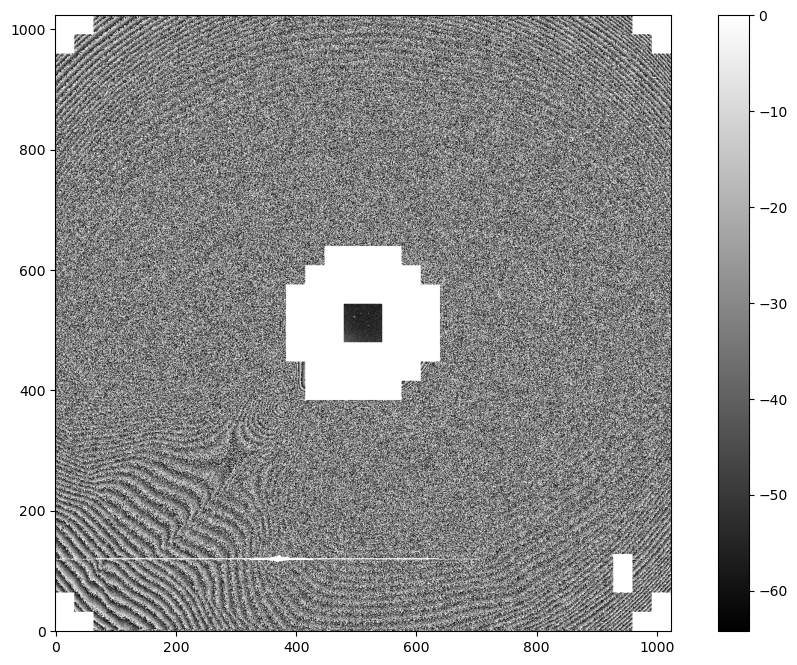

In [11]:
import numpy as np
from dataset import load_file_list
from config import PATH
import os
from astropy.io import fits
import matplotlib.pyplot as plt
import io

def byte_scale(img):
    img_min = img.min()
    img_max = img.max()
    scaled_img = (img - img_min) / (img_max - img_min) * 255.0
    return np.clip(scaled_img, 0, 255).astype(np.uint8)

def de_scale(maxv,minv, out):
    res = (out / 255.0) * (maxv - minv) + minv
    return res

def compress_rice(data):
    """Compress image using RICE compression"""
    data = byte_scale(data)
    compressed_hdu = fits.CompImageHDU(data=data, compression_type='RICE_1', tile_shape=(2,2))
    with io.BytesIO() as buffer:
        compressed_hdu.writeto(buffer)
        compressed_size = buffer.tell()
        buffer.seek(0)
        
    restored = compressed_hdu.data

    return compressed_size, restored

def calculate_psnr(img1, img2, max_val=65535):
    """Calculate PSNR between two images"""
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(max_val / np.sqrt(mse))

lst = load_file_list("data1024test.txt")
img_path = os.path.join(PATH,lst[0])
image = fits.open(img_path)[0].data
image = np.where(image<0., 0., image)
maxv = image.max()
minv = image.min()
rice_compressed_size, rice_decompressed = compress_rice(image)
rice_decompressed = de_scale(maxv, minv, rice_decompressed)
rice_psnr = calculate_psnr(image, rice_decompressed)
print(rice_psnr)
plt.figure(figsize=(12,8))
plt.imshow(rice_decompressed - image,origin="lower",cmap="gray")
plt.colorbar()
# 65.19385707414267

In [1]:
# JPEG, RICE test
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from skimage.metrics import structural_similarity as ssim
from skimage.transform import rescale
import os
from PIL import Image
import io
from torch.utils.data import random_split
import torch
from tqdm import tqdm
from transforms import get_ori_transform
from config import PATH
from dataset import get_datasets
from torch.utils.data import DataLoader

def byte_scale(img):
    img_min = img.min()
    img_max = img.max()
    scaled_img = (img - img_min) / (img_max - img_min) * 255.0
    return np.clip(scaled_img, 0, 255).astype(np.uint8)

def de_scale(maxv,minv, out):
    res = (out / 255.0) * (maxv - minv) + minv
    return res

def calculate_psnr(img1, img2, max_val=65535):
    """Calculate PSNR between two images"""
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(max_val / np.sqrt(mse))

def calculate_ms_ssim(img1, img2, scales=5):
    """Calculate MS-SSIM between two images"""
    if img1.shape != img2.shape:
        raise ValueError("Input images must have the same dimensions.")
    
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)

    ms_ssim = []
    for scale in range(scales):
        img1_rescaled = rescale(img1, scale=0.5 ** scale, mode='reflect', anti_aliasing=True)
        img2_rescaled = rescale(img2, scale=0.5 ** scale, mode='reflect', anti_aliasing=True)

        ssim_value = ssim(img1_rescaled, img2_rescaled, data_range=img1_rescaled.max() - img1_rescaled.min())
        ms_ssim.append(ssim_value)
    
    return np.prod(ms_ssim) ** (1 / scales)

def compress_jpeg(img, quality):
    """Compress image using JPEG with specified quality"""
    # Convert to uint8 for JPEG compression
    img = byte_scale(img)
    
    # Compress using PIL
    img_pil = Image.fromarray(img)
    buffer = io.BytesIO()
    img_pil.save(buffer, format='JPEG', quality=quality)
    compressed_size = buffer.tell()
    
    # Decompress
    buffer.seek(0)
    decompressed = Image.open(buffer)
    decompressed = np.array(decompressed)
    
    # Scale back to original range
    decompressed = (decompressed / 255.0 * (img.max() - img.min()) + img.min()).astype(np.int16)
    
    return compressed_size, decompressed

def compress_rice(data):
    """Compress image using RICE compression"""
    data = byte_scale(data)
    compressed_hdu = fits.CompImageHDU(data=data, compression_type='RICE_1', tile_shape=(256,256))
    with io.BytesIO() as buffer:
        compressed_hdu.writeto(buffer)
        compressed_size = buffer.tell()
        buffer.seek(0)
        
    restored = compressed_hdu.data
    # restored = restored[np.newaxis, np.newaxis, ...] # (1, 1, height, width)

    return compressed_size, restored

def load_file_list(txt_path):
    with open(txt_path, 'r') as f:
        return [line.strip() for line in f.readlines()]

def get_dataset(txt_path, train_ratio=0.7, val_ratio=0.2):

    full_list = load_file_list(txt_path)
    total = len(full_list)
    n_train = int(total * train_ratio)
    n_val = int(total * val_ratio)
    n_test = total - n_train - n_val
    generator1 = torch.Generator().manual_seed(42)

    train_name_lst, val_name_lst, test_name_lst = random_split(full_list, [n_train, n_val, n_test], generator=generator1)
  
    return train_name_lst, val_name_lst, test_name_lst


img = np.random.randint(0, 65535, size=(1024, 1024), dtype=np.uint16)

jpeg_qualities = [1, 50, 90, 95, 100]

# Initialize lists to store results
data1024_filename = 'data1024lst.txt'


j1_bpp_tot = 0
j50_bpp_tot = 0
j90_bpp_tot = 0
j95_bpp_tot = 0
j100_bpp_tot = 0
j1_psnr_tot = 0
j50_psnr_tot = 0
j90_psnr_tot = 0
j95_psnr_tot = 0
j100_psnr_tot = 0
j1_mssim_tot = 0
j50_mssim_tot = 0
j90_mssim_tot = 0
j95_mssim_tot = 0
j100_mssim_tot = 0

r_bpp_tot = 0
r_psnr_tot = 0
r_mssim_tot = 0

# test data 갖고오기
ori_transform = get_ori_transform()

_, _, _test_set = get_datasets(data1024_filename ,transform=ori_transform)

_test_loader = DataLoader(_test_set, batch_size=1, shuffle=False)


# xx = 0
# xy = 4
with torch.no_grad():
    for image in tqdm( _test_loader):
        # if xx == xy: ###########################################################
        #     break
        image = image.squeeze()
        image = image.cpu().numpy()
        maxv, minv = image.max(), image.min()
        # jpeg
        for quality in jpeg_qualities:
            jpeg_compressed_size, jpeg_decompressed = compress_jpeg(image, quality)
            
            jpeg_decompressed = de_scale(maxv, minv, jpeg_decompressed)
            jpeg_bpp = (jpeg_compressed_size * 8) / (1024 * 1024)  # bits per pixel
            jpeg_psnr = calculate_psnr(image, jpeg_decompressed)
            jpeg_ms_ssim = calculate_ms_ssim(image, jpeg_decompressed)

            if quality == 1:
                j1_bpp_tot += jpeg_bpp
                j1_psnr_tot += jpeg_psnr
                j1_mssim_tot += jpeg_ms_ssim
            elif quality == 50:
                j50_bpp_tot += jpeg_bpp
                j50_psnr_tot += jpeg_psnr
                j50_mssim_tot += jpeg_ms_ssim
            elif quality == 90:
                j90_bpp_tot += jpeg_bpp
                j90_psnr_tot += jpeg_psnr
                j90_mssim_tot += jpeg_ms_ssim
            elif quality == 95:
                j95_bpp_tot += jpeg_bpp
                j95_psnr_tot += jpeg_psnr
                j95_mssim_tot += jpeg_ms_ssim
            elif quality == 100:
                j100_bpp_tot += jpeg_bpp
                j100_psnr_tot += jpeg_psnr
                j100_mssim_tot += jpeg_ms_ssim
            else:
                print("no qual")
                break
            
            

        # Test RICE compression
        rice_compressed_size, rice_decompressed = compress_rice(image)
        rice_decompressed = de_scale(maxv, minv, rice_decompressed)
        rice_bpp = (rice_compressed_size * 8) / (1024 * 1024)
        rice_psnr = calculate_psnr(image, rice_decompressed)
        rice_ms_ssim = calculate_ms_ssim(image, rice_decompressed)


        r_bpp_tot += rice_bpp
        r_psnr_tot += rice_psnr
        r_mssim_tot += rice_ms_ssim


        # xx += 1 #######################################

count = len(_test_set) # len(test_set) ######################################

j1_avg_bpp = j1_bpp_tot/count
j1_avg_psnr = j1_psnr_tot/count
j1_avg_mssim = j1_mssim_tot/count
j50_avg_bpp = j50_bpp_tot/count
j50_avg_psnr = j50_psnr_tot/count
j50_avg_mssim = j50_mssim_tot/count
j90_avg_bpp = j90_bpp_tot/count
j90_avg_psnr = j90_psnr_tot/count
j90_avg_mssim = j90_mssim_tot/count
j95_avg_bpp = j95_bpp_tot/count
j95_avg_psnr = j95_psnr_tot/count
j95_avg_mssim = j95_mssim_tot/count
j100_avg_bpp = j100_bpp_tot/count
j100_avg_psnr = j100_psnr_tot/count
j100_avg_mssim = j100_mssim_tot/count

j_bpp_lst = [j1_avg_bpp, j50_avg_bpp, j90_avg_bpp, j95_avg_bpp, j100_avg_bpp]
j_psnr_lst = [j1_avg_psnr, j50_avg_psnr, j90_avg_psnr, j95_avg_psnr, j100_avg_psnr]
j_mssim_lst = [j1_avg_mssim, j50_avg_mssim, j90_avg_mssim, j95_avg_mssim, j100_avg_mssim]

r_avg_bpp = r_bpp_tot/count
r_avg_psnr = r_psnr_tot/count
r_avg_mssim = r_mssim_tot/count



100%|██████████| 2064/2064 [25:41<00:00,  1.34it/s]


In [2]:
j_bpp_lst = np.round(np.array(j_bpp_lst),4)
j_psnr_lst = np.round(np.array(j_psnr_lst),4)
j_mssim_lst = np.round(np.array(j_mssim_lst),4)

print(j_bpp_lst)
print(j_psnr_lst)
print(j_mssim_lst)

print(r_avg_bpp)
print(r_avg_bpp)
print(r_avg_mssim)



[0.0274 0.0467 0.1028 0.1655 0.3714]
[41.8143 59.8085 64.7982 65.5608 65.9808]
[0.8242 0.9949 0.9991 0.9993 0.9994]
0.5204879405886628
0.5204879405886628
0.9995619896953669


In [3]:
print(j_bpp_lst)
print(j_psnr_lst)
print(j_mssim_lst)

print(r_avg_bpp)
print(r_avg_psnr)
print(r_avg_mssim)

[0.0274 0.0467 0.1028 0.1655 0.3714]
[41.8143 59.8085 64.7982 65.5608 65.9808]
[0.8242 0.9949 0.9991 0.9993 0.9994]
0.5204879405886628
66.58166248751074
0.9995619896953669


In [4]:
jpg_quality = [1, 50, 90, 95, 100]
jpg_bpp = [0.0274, 0.0467, 0.1028, 0.1655, 0.3714]
jpg_psnr = [41.8143, 59.8085, 64.7982, 65.5608, 65.9808]
jpg_ms_ssim = [0.8242, 0.9949, 0.9991, 0.9993, 0.9994]
#
rice_bpp = 0.5204879405886628
rice_psnr = 66.58166248751074
rice_ms_ssim = 0.9995619896953669

In [ ]:
# jpg_quality = [1, 50, 90, 95, 100]
# jpg_bpp = [0.0993, 0.1457, 0.307,  0.5609, 1.8886]
# jpg_psnr = [41.3967, 59.905,  63.3121, 63.7019, 64.7734]
# jpg_ms_ssim = [0.8512, 0.9952, 0.9985, 0.9988, 0.9991]
# #
# rice_bpp = 2.068548867868823
# rice_psnr = 65.84686894824344
# rice_ms_ssim = 0.999494200540106

[0.85115095 0.9952057  0.99852223 0.99875517 0.99914761]


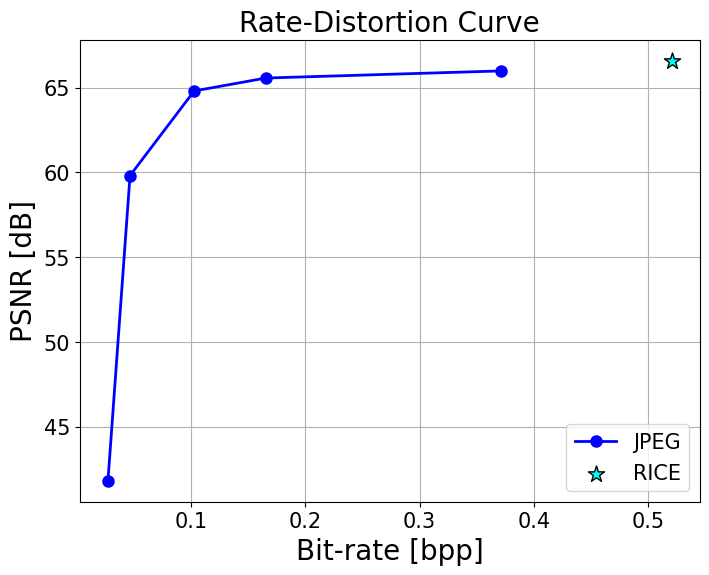

In [5]:
# plot psnr vs bpp

plt.figure(figsize=(8, 6))
# plt.plot(cheng_r, cheng_psnr, 'red', linewidth=2, marker='o', markersize=8, label='Pretrained AI model')
plt.plot(j_bpp_lst, j_psnr_lst, 'blue', linewidth=2, marker='o', markersize=8, label='JPEG')
plt.scatter(r_avg_bpp, r_avg_psnr, s=150, c='cyan', marker='*', label='RICE', zorder=2, edgecolor='black')
# plt.scatter(our_r, our_psnr, s=150, c='orange', marker='*', label='Fine-tuned AI model', zorder=2, edgecolor='black')
plt.xlabel('Bit-rate [bpp]', fontsize=20)
plt.ylabel('PSNR [dB]', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Rate-Distortion Curve', fontsize=20)
plt.grid(True)
plt.legend(fontsize=15)
# plt.xscale('log')
# plt.yscale('log')

# plt.xlim(0.05, 5)
# plt.ylim(5, 60)

plt.show()

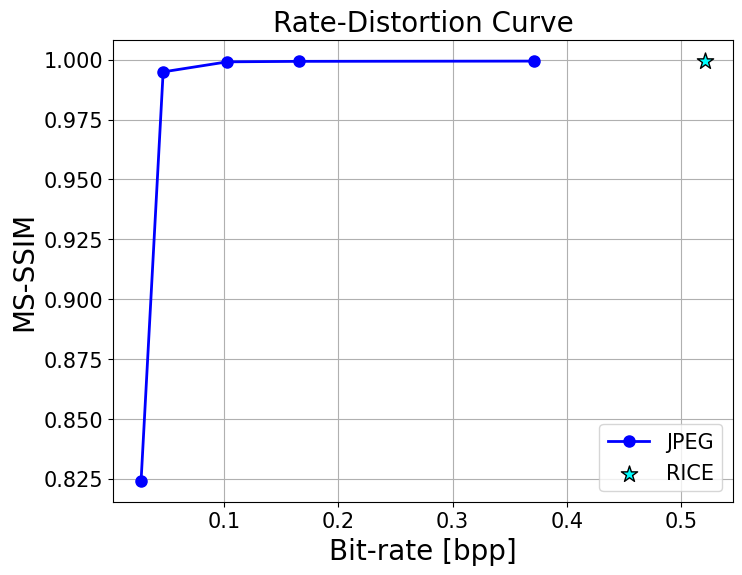

In [6]:
# plot ms-ssim vs bpp

plt.figure(figsize=(8, 6))
# plt.plot(cheng_r, cheng_ssim, 'red', linewidth=2, marker='o', markersize=8, label='Pretrained AI model')
plt.plot(j_bpp_lst, j_mssim_lst, 'blue', linewidth=2, marker='o', markersize=8, label='JPEG')
plt.scatter(r_avg_bpp, r_avg_mssim, s=150, c='cyan', marker='*', label='RICE', zorder=2, edgecolor='black')
# plt.scatter(our_r, our_ssim, s=150, c='orange', marker='*', label='Fine-tuned AI model', zorder=2, edgecolor='black')
plt.xlabel('Bit-rate [bpp]', fontsize=20)
plt.ylabel('MS-SSIM', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Rate-Distortion Curve', fontsize=20)
plt.grid(True)
plt.legend(fontsize=15)

In [ ]:
jpg_quality = [1, 50, 90, 95, 100]
jpg_bpp = [0.0274, 0.0467, 0.1028, 0.1655, 0.3714]
jpg_psnr = [41.8143, 59.8085, 64.7982, 65.5608, 65.9808]
jpg_ms_ssim = [0.8242, 0.9949, 0.9991, 0.9993, 0.9994]

rice_bpp = 0.5204879405886628
rice_psnr = 66.58166248751074
rice_ms_ssim = 0.9995619896953669

pt_bpp = [0.04857154, 0.04674372, 0.03186241, 0.02490902, 0.02186425, 0.0160078]
pt_psnr = [59.73145, 55.27617, 56.66549, 55.02037, 51.606537, 51.289482]
pt_mssim = [0.99756804, 0.99532679, 0.99474578, 0.99007912, 0.99048218, 0.99047563]
pt_mse = [5731.7075, 18151.32, 11262.903, 19050.06, 34901.06, 44258.83]

ft_bpp = 0.0031216633560265912
ft_psnr = 63.70394
ft_mssim = 0.9989381640887568
ft_mse = 2642.5527

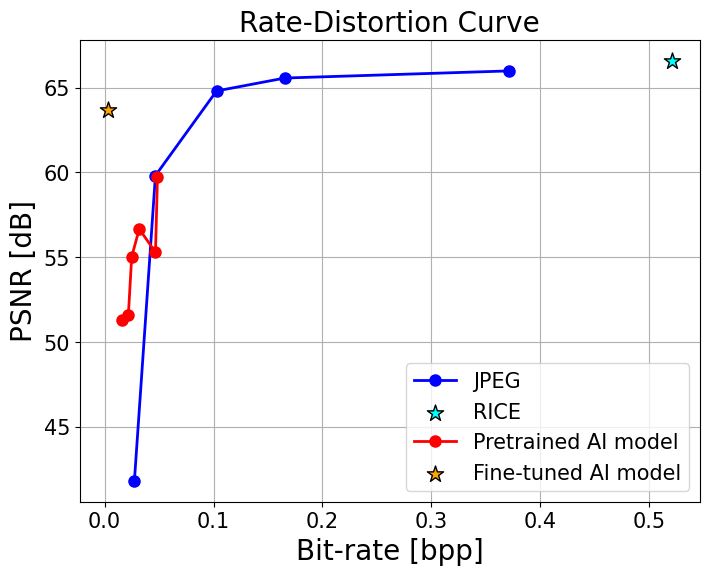

In [8]:
# plot psnr vs bpp

plt.figure(figsize=(8, 6))
plt.plot(j_bpp_lst, j_psnr_lst, 'blue', linewidth=2, marker='o', markersize=8, label='JPEG')
plt.scatter(r_avg_bpp, r_avg_psnr, s=150, c='cyan', marker='*', label='RICE', zorder=2, edgecolor='black')
plt.plot(pt_bpp, pt_psnr, 'red', linewidth=2, marker='o', markersize=8, label='Pretrained AI model')
plt.scatter(ft_bpp, ft_psnr, s=150, c='orange', marker='*', label='Fine-tuned AI model', zorder=2, edgecolor='black')
plt.xlabel('Bit-rate [bpp]', fontsize=20)
plt.ylabel('PSNR [dB]', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Rate-Distortion Curve', fontsize=20)
plt.grid(True)
plt.legend(fontsize=15)

plt.show()

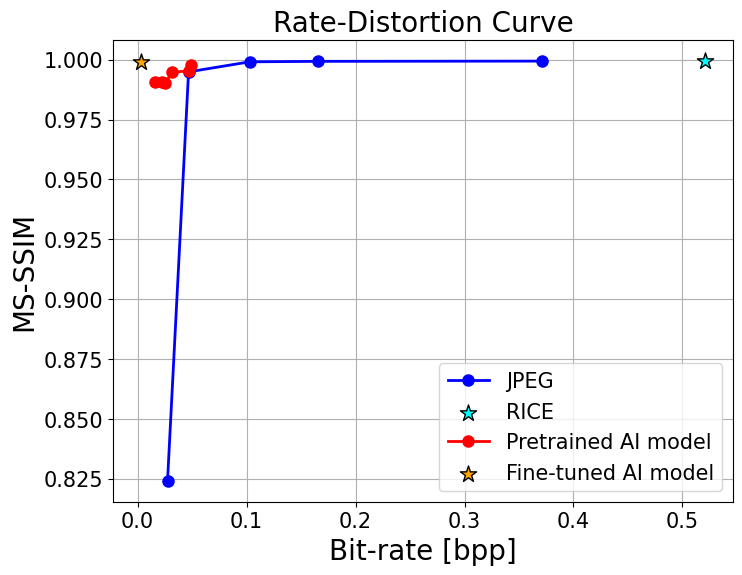

In [10]:
# plot ms-ssim vs bpp

plt.figure(figsize=(8, 6))
plt.plot(j_bpp_lst, j_mssim_lst, 'blue', linewidth=2, marker='o', markersize=8, label='JPEG')
plt.scatter(r_avg_bpp, r_avg_mssim, s=150, c='cyan', marker='*', label='RICE', zorder=2, edgecolor='black')
plt.plot(pt_bpp, pt_mssim, 'red', linewidth=2, marker='o', markersize=8, label='Pretrained AI model')
plt.scatter(ft_bpp, ft_mssim, s=150, c='orange', marker='*', label='Fine-tuned AI model', zorder=2, edgecolor='black')
plt.xlabel('Bit-rate [bpp]', fontsize=20)
plt.ylabel('MS-SSIM', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Rate-Distortion Curve', fontsize=20)
plt.grid(True)
plt.legend(fontsize=15)